In [1]:
# Ensure the project root is in the Python path
import sys
sys.path.append('/Users/tl759k/Documents/GitHub/work/cursor-analytics')

# Activate the virtual environment (if not already activated)
# This is typically done outside the notebook, but we ensure the path is correct here
import os
os.system('source /Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/bin/activate')

# Re-import the SnowflakeHook after ensuring the path is set
from utils.snowflake_connection import SnowflakeHook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
import seaborn as sns
import statsmodels.formula.api as smf
from decimal import Decimal
import plotly.express as px


# Create the Snowflake connection hook once
snowhook = SnowflakeHook()

# Function for queries
def load_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    df = snowhook.query_snowflake(query, method='pandas')

    # format Decimal -> float
    for col in df.columns:
        if df[col].dtype == 'object' and isinstance(df[col].dropna().iloc[0], Decimal):
            df[col] = df[col].astype(float)
    return df


2025-09-23 11:14:52,176 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-23 11:14:52,177 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as pe
# import plotly.graph_objects as go
import seaborn as sns
import statsmodels.formula.api as smf
from decimal import Decimal

In [3]:
def _r2_fast(y, yhat):
    """Fast R² on numpy arrays (returns -inf if y is constant)."""
    ss_tot = np.square(y - y.mean()).sum()
    if ss_tot == 0:
        return -np.inf
    ss_res = np.square(y - yhat).sum()
    return 1 - ss_res / ss_tot


def _pick_scale_sat_exp(x, y, grid=None):
    """Grid-search the saturating-exponential *scale* that maximises OLS R²."""
    x = x.astype(float)
    y = y.astype(float)

    if grid is None:
        x_pos = x[x > 0]
        x_max = x_pos.max()
        x_med = np.median(x_pos)
        s_min = 1.0 / (10 * x_max)
        s_max = 10.0 / x_med
        grid = np.geomspace(s_min, s_max, 25)

    best_s, best_r2 = None, -np.inf
    for s in grid:
        tr = 1.0 - np.exp(-s * x)
        X = np.vstack([np.ones_like(tr), tr]).T
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        r2 = _r2_fast(y, X @ beta)
        if r2 > best_r2:
            best_r2, best_s = r2, s

    return best_s if best_s is not None else 1.0


# ---------- Regression runner ----------

def run_regression(df, y, x, *, kind="linear", weights=None, bin_column=None, **kwargs):
    """Fit one curve shape via GLM and return summary, prediction df, and coefficients."""
    work = df.copy()

    if kind == "linear":
        reg = x
        formula = f"{y} ~ {reg}"

    elif kind == "log":
        work["_log_x"] = np.log(work[x].replace(0, np.nan))
        reg = "_log_x"
        formula = f"{y} ~ {reg}"

    elif kind == "log_shift":
        shift = kwargs.get("shift", 1.0)
        work["_log_xs"] = np.log(work[x] + shift)
        reg = "_log_xs"
        formula = f"{y} ~ {reg}"

    elif kind == "exp":
        scale = kwargs.get("scale")
        if scale is None:
            xmax = np.nanmax(work[x].values)
            scale = xmax / 10 if xmax > 0 else 1.0
            print(f"[run_regression] Auto-selected scale={scale:.4g} for exp")
        work["_exp_x"] = np.exp(work[x] / scale)
        reg = "_exp_x"
        formula = f"{y} ~ {reg}"

    elif kind == "power":
        p = kwargs.get("p", 2.0)
        work["_pow_x"] = np.power(work[x], p)
        reg = "_pow_x"
        formula = f"{y} ~ {reg}"

    elif kind == "quadratic":
        work["_x2"] = np.square(work[x])
        reg = ["_x2", x]
        formula = f"{y} ~ {x} + _x2"

    elif kind == "sat_exp":
        scale = kwargs.get("scale")
        if scale is None:
            finite_mask = np.isfinite(work[[x, y]]).all(axis=1)
            scale = _pick_scale_sat_exp(work.loc[finite_mask, x].values,
                                        work.loc[finite_mask, y].values)
            print(f"[run_regression] Auto-selected scale={scale:.4g} for sat_exp")
        work["_sat_x"] = 1.0 - np.exp(-scale * work[x])
        reg = "_sat_x"
        formula = f"{y} ~ {reg}"

    elif kind == "hill":
        h = kwargs.get("h", 1.0)
        k_param = kwargs.get("k", 1.0)
        work["_hill_x"] = (work[x] ** h) / (k_param ** h + work[x] ** h)
        reg = "_hill_x"
        formula = f"{y} ~ {reg}"

    else:
        raise ValueError("Unsupported kind: " + kind)

    # Clean rows
    mask = np.isfinite(work[[y] + ([reg] if isinstance(reg, str) else reg)]).all(axis=1)
    if (d := len(work) - mask.sum()) > 0:
        print(f"[run_regression] Dropped {d} non-finite rows for '{kind}'.")
    work = work.loc[mask]
    if len(work) < 3:
        raise ValueError(f"Not enough observations for kind='{kind}'.")

    # Fit model
    model = smf.glm(formula=formula, data=work,
                    var_weights=weights.loc[work.index] if weights is not None else None).fit()
    params = model.params

    # Pretty formulas
    if kind == "linear":
        fstr = f"{y} = {params[x]:.10f}·{x} + {params['Intercept']:.10f}"
    elif kind == "log":
        fstr = f"{y} = {params['_log_x']:.10f}·ln({x}) + {params['Intercept']:.10f}"
    elif kind == "log_shift":
        fstr = f"{y} = {params['_log_xs']:.10f}·ln({x} + {shift}) + {params['Intercept']:.10f}"
    elif kind == "exp":
        fstr = f"{y} = {params['_exp_x']:.10f}·exp({x}/{scale:.3g}) + {params['Intercept']:.10f}"
    elif kind == "power":
        fstr = f"{y} = {params['_pow_x']:.10f}·({x}^{p}) + {params['Intercept']:.10f}"
    elif kind == "quadratic":
        fstr = f"{y} = {params['_x2']:.10f}·{x}² + {params[x]:.3f}·{x} + {params['Intercept']:.10f}"
    elif kind == "sat_exp":
        fstr = f"{y} = {params['_sat_x']:.10f}·(1 − exp(−{scale:.3g}·{x})) + {params['Intercept']:.10f}"
    else:  # hill
        h = kwargs.get("h", 1.0); k_param = kwargs.get("k", 1.0)
        fstr = f"{y} = {params['_hill_x']:.10f}·({x}^{h})/({k_param}^{h} + {x}^{h}) + {params['Intercept']:.10f}"

    # Pseudo R² fallback
    r2 = getattr(model, "prsquared", 1 - model.deviance / model.null_deviance)

    # Predictions
    x_fit = np.linspace(df[x].min(), df[x].max(), 500)
    pred_df = pd.DataFrame({x: x_fit})

    if kind == "linear":
        pass
    elif kind == "log":
        pred_df["_log_x"] = np.log(pred_df[x])
    elif kind == "log_shift":
        pred_df["_log_xs"] = np.log(pred_df[x] + shift)
    elif kind == "exp":
        pred_df["_exp_x"] = np.exp(pred_df[x] / scale)
    elif kind == "power":
        pred_df["_pow_x"] = np.power(pred_df[x], p)
    elif kind == "quadratic":
        pred_df["_x2"] = np.square(pred_df[x])
    elif kind == "sat_exp":
        pred_df["_sat_x"] = 1.0 - np.exp(-scale * pred_df[x])
    else:  # hill
        pred_df["_hill_x"] = (pred_df[x] ** h) / (k_param ** h + pred_df[x] ** h)

    y_fit = model.predict(pred_df)
    pred_df[y] = y_fit


    # Build summary with normalized coefficient names
    coef_dict = params.to_dict()
    if x in coef_dict:  # rename the main predictor to "x_col"
        coef_dict["x_col"] = coef_dict.pop(x)

    summary = pd.DataFrame({
        "kind": [kind],
        "formula": [fstr],
        "r2": [round(r2, 4)],
        **{coef: [val] for coef, val in coef_dict.items()}
    })


    # Plot
    import seaborn as sns
    plt.figure(figsize=(7, 4))
    if bin_column and bin_column in df.columns:
        unique_bins = df[bin_column].dropna().unique()
        palette = sns.color_palette("tab10", len(unique_bins))
        bin_color_map = dict(zip(unique_bins, palette))
        colors = df[bin_column].map(bin_color_map)
        plt.scatter(df[x], df[y], c=colors, alpha=0.5)
        for label, color in bin_color_map.items():
            plt.scatter([], [], c=[color], label=str(label))
    else:
        plt.scatter(df[x], df[y], alpha=0.5, label="Actual")

    plt.plot(x_fit, y_fit, "r-", label=f"{kind} (R²={r2:.3f})")
    plt.title(f"{kind.replace('_', ' ').title()} fit: {y} vs {x}")
    plt.xlabel(x); plt.ylabel(y)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # summary = pd.DataFrame({"metric": [y], "formula": [fstr], "r2": [round(r2, 4)]})

    return summary, pred_df


# ---------- Fit multiple shapes ----------

def fit_all_curves(df, x_col, y_col, *, shapes=None, weights=None, bin_columns=None, **per_shape_kwargs):
    """Fit multiple curve shapes and summarise results.
       Returns: (best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df)
    """
    if shapes is None:
        shapes = SHAPES

    results = []
    fitted_dfs = {}
    summaries = []

    for kind in shapes:
        kw = per_shape_kwargs.get(kind, {})
        try:
            summ, pred_df = run_regression(df, y_col, x_col, kind=kind,
                                           weights=weights, bin_column=bin_columns, **kw)
            results.append((kind, summ.loc[0, "formula"], summ.loc[0, "r2"]))
            fitted_dfs[kind] = pred_df
            summaries.append(summ)
        except Exception as err:
            print(f"[{kind}] FAILED → {err}")
            results.append((kind, None, -np.inf))
            fitted_dfs[kind] = None

    results_df = pd.DataFrame(results, columns=["kind", "formula", "r2"])
    coef_df = pd.concat(summaries, ignore_index=True) if summaries else pd.DataFrame()

    # Pick best model
    best_kind, best_formula, best_r2 = max(results, key=lambda t: t[2])
    if best_formula is not None:
        print(f"\nBest Model → {best_kind}  (R²={best_r2:.4f})")
        best_fit_df = fitted_dfs[best_kind]
    else:
        print("\nNo model fit succeeded.")
        best_fit_df = None

    return best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df



In [4]:
def pred_formula(s, df):

    if df['kind'][0] == "power":
        
        intercept = df['Intercept'][0]
        _pow_x = df['_pow_x'][0]
        
        return (intercept + _pow_x*s**2)

    elif df['kind'][0] == "quadratic":

        intercep = df['Intercept'][0]
        _x2 = df['_x2'][0]
        x_col = df['x_col'][0]
        
        return (intercep + _x2*s**2 + x_col*s)
    
    elif df['kind'][0] == "sat_exp":
        scale = df['scale'][0]
        intercept = df['Intercept'][0]
        beta = df['_sat_x'][0]

        return intercept + beta * (1.0 - np.exp(-scale * s))

    elif df['kind'][0] == "linear":
        intercept = df['Intercept'][0]
        x_col = df['x_col'][0]

        return (intercept + x_col*s)
    
    
    else:
        print("not power or quadratic")
        return None

def inverse_model(y, df):
    kind = df['kind'][0]
    
    if kind == "power":
        a = df['_pow_x'][0]
        c = df['Intercept'][0]
        return np.sqrt((y - c) / a)   # only positive root (fits spend-style use case)
    
    elif kind == "quadratic":
        a = df['_x2'][0]
        b = df['x_col'][0]
        c = df['Intercept'][0] - y    # note: intercept - y

        disc = b**2 - 4*a*c
        if disc < 0:
            return np.nan   # no real roots
        roots = [(-b + np.sqrt(disc)) / (2*a),
                 (-b - np.sqrt(disc)) / (2*a)]
        return roots  # return both roots as a list
    
    elif kind == "sat_exp":
        scale = df['scale'][0]
        intercept = df['Intercept'][0]
        beta = df['_sat_x'][0]

        ratio = (y - intercept) / beta
        if ratio <= 0 or ratio >= 1:
            return np.nan  # outside valid range
        return -np.log(1 - ratio) / scale
    
    else:
        return None

## 1. Plot CPA Curve

In [5]:
# df_hist_cpa = load_query('./historical_cpa.sql')
df_hist_cpa = load_query('./historical_cpa.sql')

2025-09-23 11:14:52,866 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-23 11:14:52,867 - utils.snowflake_connection - INFO - Executing query (pandas)


In [6]:
df_hist_cpa.head()

df_hist_cpa['cpa'] = df_hist_cpa['paid_media_spend'] / (df_hist_cpa['paid_media_applicants'] * 0.7) # adjust for incrementality

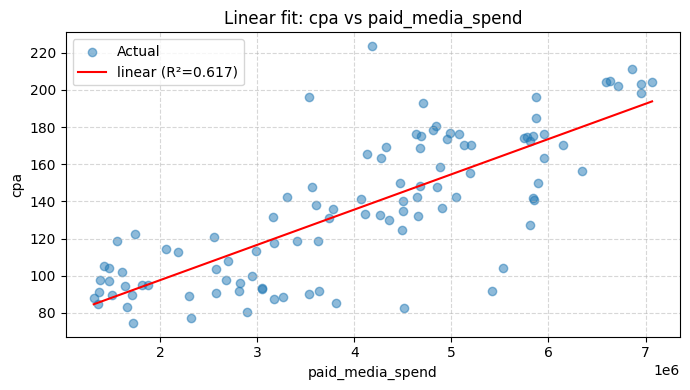


Best Model → linear  (R²=0.6165)


In [7]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["linear"]


df = df_hist_cpa.copy()


# num_bins = 5  
# percentile_cutoff = 0.9

# cost_per_total_applicant
# df['bin'] = pd.qcut(df['paid_media_applicants'], q=num_bins, labels=False, duplicates='drop')
# df['percentile'] = df.groupby('bin')['paid_media_spend'].transform(lambda x: x.rank(pct=True))
# filtered_df = df[df['percentile'] <= percentile_cutoff]
filtered_df = df.copy()
x_col = "paid_media_spend"
y_col = "cpa"


best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df = fit_all_curves(
    filtered_df,
    x_col,
    y_col,
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model

spend_cpa_coef_df = coef_df
df_spend_cpa = best_fit_df.copy()


In [8]:
spend_cpa_coef_df

,kind,formula,r2,Intercept,x_col
0,linear,cpa = 0.0000189883·paid_media_spend + 59.61142...,0.6165,59.611424,0.000019


In [9]:
best_formula

'cpa = 0.0000189883·paid_media_spend + 59.6114239607'

In [10]:

spending = np.arange(1000000, 20000001, 1000000)
# spending = np.arange(10000, 100001, 10000)

cpa = pred_formula(spending, spend_cpa_coef_df)

# build dataframe
df_prep = pd.DataFrame({
    "spending": spending,
    "cpa": cpa,
})

df_prep['applicants'] = df_prep['spending'] / df_prep['cpa']

## 2. Calculate DAC Cost Curves - Global Level

### 2.1 DAC Cost Curve (Lifetime or 52w)

In [11]:
df_prep_lifetime = df_prep.copy()

# lifetime cost curve
df_prep_lifetime['new_dx'] = df_prep_lifetime['applicants'] * 0.28 # lifetime conversion rate
df_prep_lifetime['hours'] = df_prep_lifetime['new_dx'] * 170 # lifetime hours (52weeks)
df_prep_lifetime['wad'] = df_prep_lifetime['hours'] / 13 # online hours per dx

# calcualte marginal cost
def calc_marginal_cost(df):
    df['mcpd'] = df['spending'].diff() / df['new_dx'].diff()
    df['mcpwad'] = df['spending'].diff() / df['wad'].diff()
    df['mcpih'] = df['spending'].diff() / df['hours'].diff()
    return df

df_prep_lifetime = calc_marginal_cost(df_prep_lifetime)

df_prep_lifetime_output = df_prep_lifetime[['mcpd', 'mcpwad', 'mcpih']].dropna().reset_index(drop=True)

df_prep_lifetime_output['mcpd_vs_mcpwad'] = df_prep_lifetime_output['mcpd'] / df_prep_lifetime_output['mcpwad']
df_prep_lifetime_output['mcpd_vs_mcpih'] = df_prep_lifetime_output['mcpd'] / df_prep_lifetime_output['mcpih']

df_prep_lifetime_output

,mcpd,mcpwad,mcpih,mcpd_vs_mcpwad,mcpd_vs_mcpih
0,459.547811,35.141891,2.703222,13.076923,170.0
1,681.585441,52.121240,4.009326,13.076923,170.0
2,946.826359,72.404369,5.569567,13.076923,170.0
3,1255.270566,95.991279,7.383945,13.076923,170.0
4,1606.918062,122.881969,9.452459,13.076923,170.0
5,2001.768846,153.076441,11.775111,13.076923,170.0
6,2439.822919,186.574694,14.351900,13.076923,170.0
7,2921.080281,223.376727,17.182825,13.076923,170.0
8,3445.540931,263.482542,20.267888,13.076923,170.0
9,4013.204869,306.892137,23.607087,13.076923,170.0


In [12]:
df_prep_lifetime

,spending,cpa,applicants,new_dx,hours,wad,mcpd,mcpwad,mcpih
0,1000000,78.599771,12722.683319,3562.351329,6.055997e+05,46584.594305,NaN,NaN,NaN
1,2000000,97.588119,20494.298130,5738.403476,9.755286e+05,75040.660844,459.547811,35.141891,2.703222
2,3000000,116.576466,25734.182022,7205.570966,1.224947e+06,94226.697249,681.585441,52.121240,4.009326
3,4000000,135.564814,29506.181541,8261.730831,1.404494e+06,108038.018564,946.826359,72.404369,5.569567
4,5000000,154.553161,32351.327971,9058.371832,1.539923e+06,118455.631648,1255.270566,95.991279,7.383945
5,6000000,173.541508,34573.861065,9680.681098,1.645716e+06,126593.522052,1606.918062,122.881969,9.452459
6,7000000,192.529856,36357.997419,10180.239277,1.730641e+06,133126.205933,2001.768846,153.076441,11.775111
7,8000000,211.518203,37821.803887,10590.105088,1.800318e+06,138485.989618,2439.822919,186.574694,14.351900
8,9000000,230.506551,39044.443537,10932.444190,1.858516e+06,142962.731721,2921.080281,223.376727,17.182825
9,10000000,249.494898,40080.979931,11222.674381,1.907855e+06,146758.049594,3445.540931,263.482542,20.267888


### 2.2 DAC Cost Curve (26w)

In [13]:
new_dx_landing_curve = load_query("new_dx_landing_curve.sql")
new_dx_retention_curve = load_query("new_dx_retention_curve.sql")

2025-09-23 11:14:56,278 - utils.snowflake_connection - INFO - Executing query (pandas)
2025-09-23 11:14:59,155 - utils.snowflake_connection - INFO - Executing query (pandas)


In [14]:
def calc_scenario(spending, applicants, horizon = 26):

    def calc_weekly_converted_dx(new_dx_landing_curve, applicants):
        new_dx_landing_curve['new_dx'] = new_dx_landing_curve['new_dx_ratio'] * applicants
        return new_dx_landing_curve

    df_conv_dx = calc_weekly_converted_dx(new_dx_landing_curve, applicants)    

    hours_per_new_dx = 13.0 # online hours per dx

    df_retained_dx = df_conv_dx.merge(new_dx_retention_curve, how='cross')
    df_retained_dx['wad'] = df_retained_dx['new_dx'] * df_retained_dx['dx_retention']
    
    def keep_first_zero_rest(group):
        first_value = group.iloc[0]  # keep the first row’s original value
        group.iloc[1:] = 0           # set the rest to 0
        group.iloc[0] = first_value
        return group

    df_retained_dx['new_dx'] = df_retained_dx.groupby('horizon_conv')['new_dx'].transform(keep_first_zero_rest)

    df_retained_dx['horizon'] = df_retained_dx['horizon_conv'] + df_retained_dx['horizon_ret']
    df_retained_dx_26w = df_retained_dx[df_retained_dx['horizon'] <= horizon]
    df_retained_dx_26w = df_retained_dx_26w.groupby(['horizon']).agg({'wad': 'sum', 'new_dx': 'sum'}).reset_index(drop = False)
    df_retained_dx_26w['hours'] = df_retained_dx_26w['wad'] * hours_per_new_dx

    df_retained_dx_26w['spending'] = spending
    df_retained_dx_26w['applicants'] = applicants
    df_output = df_retained_dx_26w.groupby(['spending','applicants']).agg({ 'new_dx': 'sum', 'wad': 'sum','hours': 'sum'}).reset_index(drop = False)

    return df_output

In [15]:
df_prep_26w = pd.DataFrame()
for spending in np.arange(1000000, 20000001, 1000000):
# for spending in np.arange(10000, 100001, 10000):
    cpa = pred_formula(spending, spend_cpa_coef_df)
    applicants = spending / cpa
    df_output_tmp = calc_scenario(spending, applicants, horizon = 26)
    df_prep_26w = pd.concat([df_prep_26w, df_output_tmp])

df_prep_26w = calc_marginal_cost(df_prep_26w)
df_prep_26w_output = df_prep_26w[['mcpd', 'mcpwad', 'mcpih']].dropna().reset_index(drop=True)
df_prep_26w_output['mcpd_vs_mcpwad'] = df_prep_26w_output['mcpd'] / df_prep_26w_output['mcpwad']
df_prep_26w_output['mcpd_vs_mcpih'] = df_prep_26w_output['mcpd'] / df_prep_26w_output['mcpih']
df_prep_26w_output

,mcpd,mcpwad,mcpih,mcpd_vs_mcpwad,mcpd_vs_mcpih
0,580.822514,75.515311,5.808870,7.691454,99.988897
1,861.455893,112.001701,8.615515,7.691454,99.988897
2,1196.693911,155.587483,11.968268,7.691454,99.988897
3,1586.536569,206.272656,15.867127,7.691454,99.988897
4,2030.983867,264.057221,20.312094,7.691454,99.988897
5,2530.035804,328.941177,25.303167,7.691454,99.988897
6,3083.692382,400.924524,30.840348,7.691454,99.988897
7,3691.953599,480.007263,36.923636,7.691454,99.988897
8,4354.819457,566.189393,43.553030,7.691454,99.988897
9,5072.289954,659.470914,50.728532,7.691454,99.988897


In [16]:
df_prep_52w = pd.DataFrame()
for spending in np.arange(1000000, 20000001, 1000000):
# for spending in np.arange(10000, 100001, 10000):
    cpa = pred_formula(spending, spend_cpa_coef_df)
    applicants = spending / cpa
    df_output_tmp = calc_scenario(spending, applicants, horizon = 52)
    df_prep_52w = pd.concat([df_prep_52w, df_output_tmp])

df_prep_52w = calc_marginal_cost(df_prep_52w)
df_prep_52w_output = df_prep_52w[['mcpd', 'mcpwad', 'mcpih']].dropna().reset_index(drop=True)
df_prep_52w_output['mcpd_vs_mcpwad'] = df_prep_52w_output['mcpd'] / df_prep_52w_output['mcpwad']
df_prep_52w_output['mcpd_vs_mcpih'] = df_prep_52w_output['mcpd'] / df_prep_52w_output['mcpih']
df_prep_52w_output


,mcpd,mcpwad,mcpih,mcpd_vs_mcpwad,mcpd_vs_mcpih
0,528.284187,48.016420,3.693571,11.002157,143.02804
1,783.532860,71.216296,5.478177,11.002157,143.02804
2,1088.446907,98.930320,7.610025,11.002157,143.02804
3,1443.026330,131.158494,10.089115,11.002157,143.02804
4,1847.271127,167.900816,12.915447,11.002157,143.02804
5,2301.181298,209.157287,16.089022,11.002157,143.02804
6,2804.756844,254.927908,19.609839,11.002157,143.02804
7,3357.997765,305.212677,23.477898,11.002157,143.02804
8,3960.904060,360.011595,27.693200,11.002157,143.02804
9,4613.475730,419.324662,32.255743,11.002157,143.02804


### 2.3 Global Spending <> mCPD Scenario

df_prep_26w_output: based on new dx conversion and landing curve, actual mCPD <> mCPWAD <> mCPIH

df_prep_lifetime_output: based on lifetime new dx conversion and lifetime hours, actual mCPD <> mCPWAD <> mCPIH

In [17]:
df_sim_output = load_query("all_sms_daco_output.sql")

2025-09-23 11:15:11,103 - utils.snowflake_connection - INFO - Executing query (pandas)


In [18]:
df_sm0 = df_sim_output[df_sim_output['submarket_id'] == 0]

df_sm0_spend_mcpd = df_sm0[['mcpd_scenario', 'spending']]

df_sm0_spend_mcpd

,mcpd_scenario,spending
0,1000,4.669642e+05
1,2000,1.328705e+06
2,3000,2.254686e+06
3,4000,3.036463e+06
4,5000,3.797443e+06
5,6000,4.425450e+06
6,7000,4.965759e+06
7,8000,5.418885e+06
8,9000,5.807385e+06
9,10000,6.118613e+06


In [19]:
df_sm0_spend_mcpd['spending'] / df_sm0_spend_mcpd['mcpd_scenario']

0     466.964214
1     664.352441
2     751.561902
3     759.115760
4     759.488553
5     737.574981
6     709.394119
7     677.360594
8     645.265005
9     611.861293
10    584.254693
11    558.686973
dtype: float64

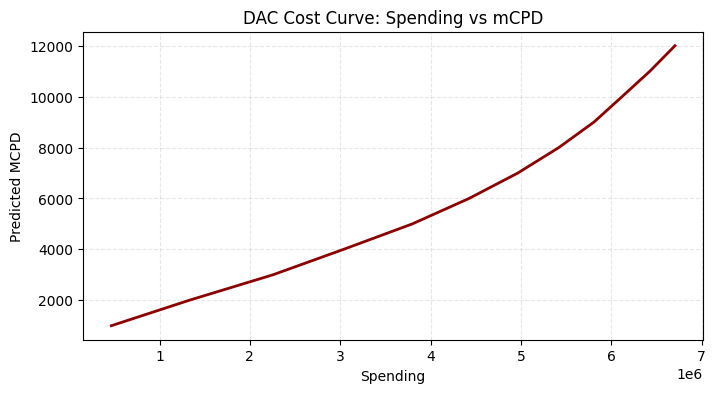

In [20]:
import matplotlib.pyplot as plt

# make a sorted copy to avoid scrambled line
df = df_sm0_spend_mcpd.copy()
df_sorted = df.sort_values(by="spending")

plt.figure(figsize=(8, 4))
plt.plot(df_sorted['spending'], df_sorted['mcpd_scenario'], color="darkred", linewidth=2)

plt.title("DAC Cost Curve: Spending vs mCPD")
plt.xlabel("Spending")
plt.ylabel("Predicted MCPD")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


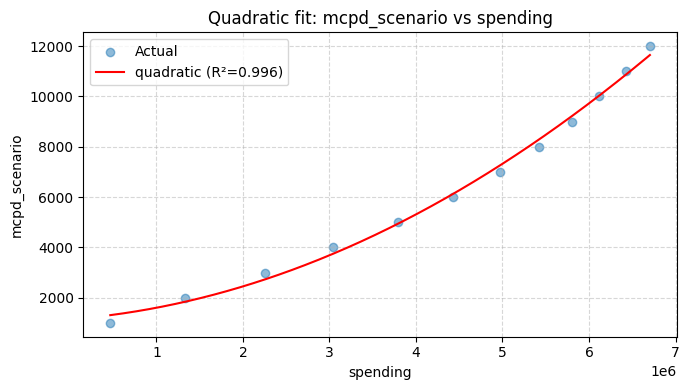


Best Model → quadratic  (R²=0.9957)


In [21]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["quadratic"]

df_plot = df_sm0_spend_mcpd.copy()
x_col = "spending"
y_col = "mcpd_scenario"


best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df = fit_all_curves(
   df_plot,
    x_col,
    y_col,
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

In [22]:
spending_mcpd_coef_df = coef_df
df_fit_output = best_fit_df.copy()

df_fit_output = df_fit_output[['spending', 'mcpd_scenario']]
df_fit_output.rename(columns={'mcpd_scenario': 'pred_mcpd'}, inplace=True)

In [23]:
mcpd_vs_mcpwad_26w = df_prep_26w_output['mcpd_vs_mcpwad'].values[0]
mcpd_vs_mcpih_26w = df_prep_26w_output['mcpd_vs_mcpih'].values[0]

mcpd_vs_mcpwad_52w = df_prep_52w_output['mcpd_vs_mcpwad'].values[0]
mcpd_vs_mcpih_52w = df_prep_52w_output['mcpd_vs_mcpih'].values[0]

mcpd_vs_mcpwad_lifetime = df_prep_lifetime_output['mcpd_vs_mcpwad'].values[0]
mcpd_vs_mcpih_lifetime = df_prep_lifetime_output['mcpd_vs_mcpih'].values[0]

mcpd_vs_mcpwad_26w, mcpd_vs_mcpih_26w, mcpd_vs_mcpwad_52w, mcpd_vs_mcpih_52w, mcpd_vs_mcpwad_lifetime, mcpd_vs_mcpih_lifetime


(7.691453624211384,
 99.98889711474797,
 11.002156921960525,
 143.02803998548683,
 13.076923076923078,
 170.0)

In [24]:
df_fit_output['pred_mcpwad_26w'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpwad_26w
df_fit_output['pred_mcpih_26w'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpih_26w

df_fit_output['pred_mcpwad_52w'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpwad_52w
df_fit_output['pred_mcpih_52w'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpih_52w

df_fit_output['pred_mcpwad_lifetime'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpwad_lifetime
df_fit_output['pred_mcpih_lifetime'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpih_lifetime

df_fit_output

,spending,pred_mcpd,pred_mcpwad_26w,pred_mcpih_26w,pred_mcpwad_52w,pred_mcpih_52w,pred_mcpwad_lifetime,pred_mcpih_lifetime
0,4.669642e+05,1307.484098,169.991807,13.076293,118.838888,9.141453,99.984078,7.691083
1,4.794638e+05,1313.113097,170.723658,13.132589,119.350515,9.180809,100.414531,7.724195
2,4.919633e+05,1318.802716,171.463390,13.189492,119.867652,9.220589,100.849619,7.757663
3,5.044629e+05,1324.552957,172.211005,13.247000,120.390299,9.260792,101.289344,7.791488
4,5.169624e+05,1330.363818,172.966501,13.305115,120.918455,9.301420,101.733704,7.825670
...,...,...,...,...,...,...,...,...
495,6.654245e+06,11505.650699,1495.900679,115.069283,1045.763188,80.443322,879.843877,67.680298
496,6.666745e+06,11541.287035,1500.533917,115.425686,1049.002220,80.692478,882.569009,67.889924
497,6.679245e+06,11576.983992,1505.175037,115.782695,1052.246762,80.942059,885.298776,68.099906
498,6.691744e+06,11612.741569,1509.824038,116.140311,1055.496813,81.192063,888.033179,68.310245


### Plot Global Curve Graph

In [25]:
df_fit_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   spending              500 non-null    float64
 1   pred_mcpd             500 non-null    float64
 2   pred_mcpwad_26w       500 non-null    float64
 3   pred_mcpih_26w        500 non-null    float64
 4   pred_mcpwad_52w       500 non-null    float64
 5   pred_mcpih_52w        500 non-null    float64
 6   pred_mcpwad_lifetime  500 non-null    float64
 7   pred_mcpih_lifetime   500 non-null    float64
dtypes: float64(8)
memory usage: 31.4 KB


In [26]:
df_fit_output

,spending,pred_mcpd,pred_mcpwad_26w,pred_mcpih_26w,pred_mcpwad_52w,pred_mcpih_52w,pred_mcpwad_lifetime,pred_mcpih_lifetime
0,4.669642e+05,1307.484098,169.991807,13.076293,118.838888,9.141453,99.984078,7.691083
1,4.794638e+05,1313.113097,170.723658,13.132589,119.350515,9.180809,100.414531,7.724195
2,4.919633e+05,1318.802716,171.463390,13.189492,119.867652,9.220589,100.849619,7.757663
3,5.044629e+05,1324.552957,172.211005,13.247000,120.390299,9.260792,101.289344,7.791488
4,5.169624e+05,1330.363818,172.966501,13.305115,120.918455,9.301420,101.733704,7.825670
...,...,...,...,...,...,...,...,...
495,6.654245e+06,11505.650699,1495.900679,115.069283,1045.763188,80.443322,879.843877,67.680298
496,6.666745e+06,11541.287035,1500.533917,115.425686,1049.002220,80.692478,882.569009,67.889924
497,6.679245e+06,11576.983992,1505.175037,115.782695,1052.246762,80.942059,885.298776,68.099906
498,6.691744e+06,11612.741569,1509.824038,116.140311,1055.496813,81.192063,888.033179,68.310245


In [27]:
import matplotlib.pyplot as plt

# make a sorted copy to avoid scrambled line
df_sorted = df.sort_values(by="spending")

plt.figure(figsize=(8, 4))
plt.plot(df_sorted['spending'], df_sorted['pred_mcpd'], color="darkred", linewidth=2)

plt.title("DAC Cost Curve: Spending vs mCPD")
plt.xlabel("Spending")
plt.ylabel("Predicted MCPD")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


KeyError: 'pred_mcpd'

<Figure size 800x400 with 0 Axes>

In [ ]:
# df_hist_cpa = load_query('./historical_cpa.sql')
df_hist_cpa = load_query('./historical_cpa.sql')

2025-09-23 00:08:20,528 - utils.snowflake_connection - INFO - Executing query (pandas)


In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as pe
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"

def plot_mcpwad_curve(df, spending_range=(None, None), mcpd_range=(1000, None), mcpd_step=1000, static_wad=280):
    """
    Plot spending vs. mCPWAD (26wks + lifetime) with markers at every `mcpd_step`,
    plus a horizontal line for static mCPWAD.

    Parameters
    ----------
    df : DataFrame
        Must contain ['spending', 'pred_mcpwad_26w', 'pred_mcpwad_lifetime', 'pred_mcpd']
    spending_range : tuple
        (xmin, xmax) for x-axis in dollars. Use None for auto.
    mcpd_range : tuple
        (min_mcpd, max_mcpd) for annotation ticks in mCPD units. Use None for auto.
    mcpd_step : int
        Step size for mCPD annotations (default=1000).
    static_wad : float
        Reference horizontal line value for mCPWAD.
    """
    # style
    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.family": ["Proxima Nova", "Helvetica Neue", "Arial"],
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": "--",
        "axes.linewidth": 0.8,
    })

    fig, ax = plt.subplots(figsize=(7,4))

    # 1) main lines
    # line1, = ax.plot(
    #     df["spending"], df["pred_mcpwad_26w"],
    #     label="DAC CPIWAD (26wks)", color="#038c0a", linewidth=1.5, zorder=2
    # )
    # line2, = ax.plot(
    #     df["spending"], df["pred_mcpwad_lifetime"],
    #     label="DAC CPIWAD (lifetime)", color="#0778b5", linewidth=1.5, zorder=2
    # )
    line4, = ax.plot(
        df["spending"], df["pred_mcpwad_52w"],
        label="DAC CPIWAD (52wks)", color="#0778b5", linewidth=1.5, zorder=2
    )

    # # # 2) static reference line
    # line3 = ax.axhline(
    #     y=static_wad, color="red", linestyle=":", linewidth=1.5,
    #     label=f"BP CPIWAD = {static_wad}"
    # )

    # 3) marks every `mcpd_step` in mCPD range
    mcpd_min = mcpd_range[0] if mcpd_range[0] is not None else df["pred_mcpd"].min()
    mcpd_max = mcpd_range[1] if mcpd_range[1] is not None else df["pred_mcpd"].max()
    mcpd_marks = np.arange(mcpd_min, mcpd_max, mcpd_step)

    spending_marks = np.interp(mcpd_marks, df["pred_mcpd"], df["spending"])
    # mcpwad26_marks = np.interp(mcpd_marks, df["pred_mcpd"], df["pred_mcpwad_26w"])
    mcpwad52_marks = np.interp(mcpd_marks, df["pred_mcpd"], df["pred_mcpwad_52w"])
    # mcpwadLT_marks = np.interp(mcpd_marks, df["pred_mcpd"], df["pred_mcpwad_lifetime"])

    # ax.scatter(spending_marks, mcpwad26_marks, marker='o', s=10, color="#038c0a", zorder=3)
    ax.scatter(spending_marks, mcpwad52_marks, marker='o', s=10, color="#0778b5", zorder=3)
    # ax.scatter(spending_marks, mcpwadLT_marks, marker='o', s=10, color="#0778b5", zorder=3) # s, as square

    # 4) annotate with mCPD labels
    halo = [pe.withStroke(linewidth=2, foreground="white")]
    # for s, y, mcpd in zip(spending_marks, mcpwad26_marks, mcpd_marks):
    #     ax.annotate(f"{int(mcpd/1000)}k", (s, y),
    #                 xytext=(0,6), textcoords="offset points",
    #                 ha="center", fontsize=7, color="#038c0a", path_effects=halo)

    for s, y, mcpd in zip(spending_marks, mcpwad52_marks, mcpd_marks):
        ax.annotate(f"{int(mcpd/1000)}k", (s, y),
                    xytext=(0,6), textcoords="offset points",
                    ha="center", fontsize=7, color="#0778b5", path_effects=halo)

    # for s, y, mcpd in zip(spending_marks, mcpwadLT_marks, mcpd_marks):
    #     ax.annotate(f"{int(mcpd/1000)}k", (s, y),
    #                 xytext=(0,-9), textcoords="offset points",
    #                 ha="center", fontsize=7, color="#0778b5", path_effects=halo)

    # 5) formatting
    xmin = spending_range[0] if spending_range[0] is not None else df["spending"].min()
    xmax = spending_range[1] if spending_range[1] is not None else df["spending"].max()
    ax.set_xlim(xmin, xmax)

    ax.set_xlabel("Paid Media Spend")
    ax.set_ylabel("CPIWAD")
    ax.set_title("DAC Cost Curve: Spending vs CPIWAD", fontweight="bold", fontsize=10)
    # ax.set_title("Global Cost Curve: Spending vs CPIWAD", fontweight="bold", fontsize=10)
    ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))  # commas

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_color("black")

    ax.legend(handles=[line4 ], fontsize=8, framealpha=0.9, loc="upper left")
    # ax.legend(handles=[line4, line3], fontsize=8, framealpha=0.9, loc="upper left")
    fig.tight_layout()
    plt.show()


In [42]:
df_fit_output

,spending,pred_mcpd,pred_mcpwad_26w,pred_mcpih_26w,pred_mcpwad_52w,pred_mcpih_52w,pred_mcpwad_lifetime,pred_mcpih_lifetime
0,4.669642e+05,1307.484098,169.991807,13.076293,118.838888,9.141453,99.984078,7.691083
1,4.794638e+05,1313.113097,170.723658,13.132589,119.350515,9.180809,100.414531,7.724195
2,4.919633e+05,1318.802716,171.463390,13.189492,119.867652,9.220589,100.849619,7.757663
3,5.044629e+05,1324.552957,172.211005,13.247000,120.390299,9.260792,101.289344,7.791488
4,5.169624e+05,1330.363818,172.966501,13.305115,120.918455,9.301420,101.733704,7.825670
...,...,...,...,...,...,...,...,...
495,6.654245e+06,11505.650699,1495.900679,115.069283,1045.763188,80.443322,879.843877,67.680298
496,6.666745e+06,11541.287035,1500.533917,115.425686,1049.002220,80.692478,882.569009,67.889924
497,6.679245e+06,11576.983992,1505.175037,115.782695,1052.246762,80.942059,885.298776,68.099906
498,6.691744e+06,11612.741569,1509.824038,116.140311,1055.496813,81.192063,888.033179,68.310245


findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not found.
findfont: Font family 'Proxima Nova' not

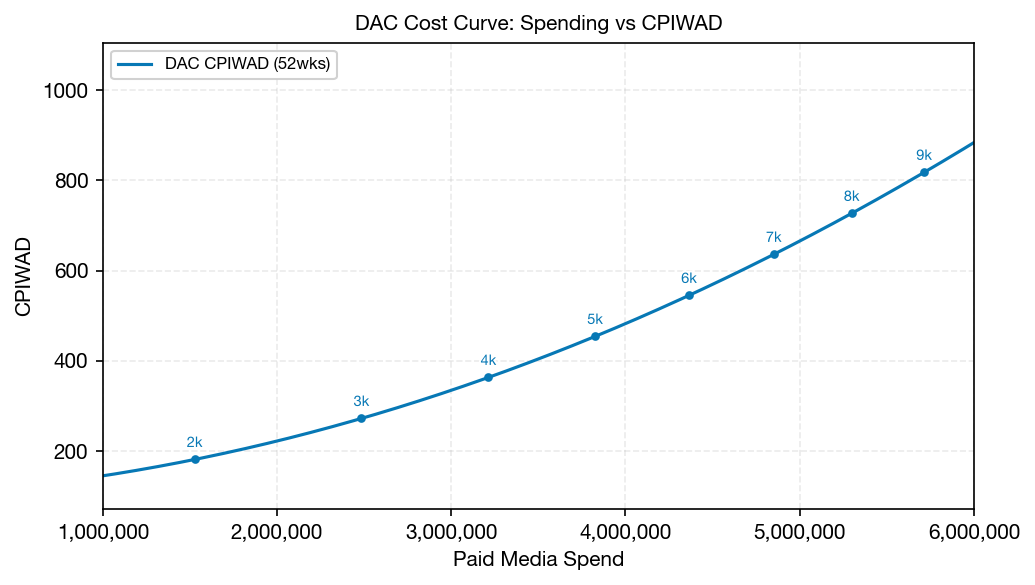

In [41]:
import warnings
warnings.filterwarnings("ignore", module="matplotlib")

# zoom in: spending 1M–8M, mCPD labels from 2000 to 8000
plot_mcpwad_curve(df_fit_output, spending_range=(1_000_000, 6_000_000), mcpd_range=(1000, 10000), mcpd_step=1000 , static_wad=280)




In [ ]:
df_fit_output[(df_fit_output['pred_mcpd'] <= 3100) & (df_fit_output['pred_mcpd'] >= 2900)]

,spending,pred_mcpd,pred_mcpwad_26w,pred_mcpih_26w,pred_mcpwad_52w,pred_mcpih_52w,pred_mcpwad_lifetime,pred_mcpih_lifetime
160,2.466894e+06,2912.535063,378.354068,29.104159,264.450168,20.342321,222.723270,17.132559
161,2.479393e+06,2926.639805,380.186351,29.245104,265.730839,20.440834,223.801867,17.215528
162,2.491893e+06,2940.815833,382.027893,29.386761,267.017984,20.539845,224.885917,17.298917
163,2.504392e+06,2955.063149,383.878697,29.529131,268.311601,20.639354,225.975417,17.382724
164,2.516892e+06,2969.381751,385.738761,29.672212,269.611690,20.739361,227.070369,17.466951
165,2.529391e+06,2983.771641,387.608085,29.816007,270.918253,20.839866,228.170773,17.551598
166,2.541891e+06,2998.232818,389.486671,29.960513,272.231288,20.940868,229.276627,17.636664
167,2.554390e+06,3012.765282,391.374516,30.105732,273.550796,21.042369,230.387933,17.722149
168,2.566890e+06,3027.369032,393.271622,30.251663,274.876776,21.144367,231.504691,17.808053
169,2.579390e+06,3042.044070,395.177989,30.398307,276.209229,21.246864,232.626899,17.894377


### Calculate avg Weekly Applicants and WAD given certain Spend

In [54]:
df_fit_output[(df_fit_output['pred_mcpd'] <= 3100) & (df_fit_output['pred_mcpd'] >= 2900)]

,spending,pred_mcpd,pred_mcpwad_26w,pred_mcpih_26w,pred_mcpwad_52w,pred_mcpih_52w,pred_mcpwad_lifetime,pred_mcpih_lifetime
155,2.404396e+06,2903.489127,377.495499,29.038115,263.901810,20.300139,222.031521,17.079348
156,2.416895e+06,2918.514363,379.448997,29.188384,265.267473,20.405190,223.180510,17.167732
157,2.429395e+06,2933.600219,381.410376,29.339260,266.638645,20.510665,224.334134,17.256472
158,2.441894e+06,2948.746696,383.379637,29.490741,268.015328,20.616564,225.492394,17.345569
159,2.454394e+06,2963.953794,385.356779,29.642829,269.397520,20.722886,226.655290,17.435022
160,2.466894e+06,2979.221513,387.341803,29.795523,270.785223,20.829633,227.822822,17.524832
161,2.479393e+06,2994.549853,389.334708,29.948824,272.178435,20.936803,228.994989,17.614999
162,2.491893e+06,3009.938814,391.335495,30.102730,273.577157,21.044397,230.171792,17.705522
163,2.504392e+06,3025.388396,393.344164,30.257243,274.981389,21.152415,231.353230,17.796402
164,2.516892e+06,3040.898599,395.360714,30.412363,276.391131,21.260856,232.539305,17.887639


In [ ]:
def keep_first_zero_rest(group):
    first_value = group.iloc[0]  # keep the first row’s original value
    group.iloc[1:] = 0           # set the rest to 0
    group.iloc[0] = first_value
    return group


def calc_scenario_weekly(spending, applicants):

    def calc_weekly_converted_dx(new_dx_landing_curve, applicants):
        new_dx_landing_curve['new_dx'] = new_dx_landing_curve['new_dx_ratio'] * applicants
        return new_dx_landing_curve

    df_conv_dx = calc_weekly_converted_dx(new_dx_landing_curve, applicants)    

    hours_per_new_dx = 13.0 # online hours per dx

    df_retained_dx = df_conv_dx.merge(new_dx_retention_curve, how='cross')
    df_retained_dx['wad'] = df_retained_dx['new_dx'] * df_retained_dx['dx_retention']
    
    df_retained_dx['new_dx'] = df_retained_dx.groupby('horizon_conv')['new_dx'].transform(keep_first_zero_rest)
    df_retained_dx['hours'] = df_retained_dx['wad'] * hours_per_new_dx

    df_retained_dx['spending'] = spending
    df_retained_dx['applicants'] = applicants
    
    df_output = df_retained_dx[['spending','applicants','horizon_conv','new_dx','horizon_ret','wad','hours']]

    return df_output

In [ ]:
spend_list = [5504400, 6076011, 6330060, 2616888, 2888642, 3009421]

results = []
for spending in spend_list:
    cpa = pred_formula(spending, spend_cpa_coef_df)  # your real coef_df goes here
    applicants = spending / cpa
    applicants_adj = applicants / 0.7
    results.append([spending, cpa, applicants, applicants_adj])

# Save results in DataFrame
df_apps_adj = pd.DataFrame(results, columns=["Spending", "CPA", "Applicants", "Applicants_Adj"])

df_apps_adj['cpa_adj'] = df_apps_adj['Spending'] / df_apps_adj['Applicants_Adj']
df_apps_adj


,Spending,CPA,Applicants,Applicants_Adj,cpa_adj
0,5504400,165.609479,33237.227960,47481.754229,115.926635
1,6076011,176.791170,34368.294555,49097.563649,123.753819
2,6330060,181.760804,34826.320462,49751.886374,127.232563
3,2616888,109.124794,23980.691257,34258.130367,76.387356
4,2888642,114.440768,25241.371946,36059.102780,80.108538
5,3009421,116.803413,25764.837960,36806.911372,81.762389


In [ ]:
df_weekly_output = pd.DataFrame()

for spending in spend_list:

    cpa = pred_formula(spending, spend_cpa_coef_df)
    applicants = spending / cpa
    applicants_adj = applicants / 0.7

    for spending_horizon in range(0, 13):

        horizon = spending_horizon 
        df_weekly_output_tmp = calc_scenario(spending, applicants, horizon)
        df_weekly_output_tmp['horizon_spend'] = spending_horizon
        df_weekly_output_tmp['spending'] = df_weekly_output_tmp.groupby('horizon_spend')['spending'].transform(keep_first_zero_rest)
        df_weekly_output_tmp['applicants'] = df_weekly_output_tmp.groupby('horizon_spend')['applicants'].transform(keep_first_zero_rest)
    
        df_weekly_output = pd.concat([df_weekly_output, df_weekly_output_tmp])

df_weekly_output['wad'].mean()

18331.56877031355

In [ ]:
spend_list = [5433831,	5960277,	3704885,	3853080,	6085890,
2616888,	2870420,	1784242,	1855611,	2930915]

df_list = []

for spending in spend_list:
    
    cpa = pred_formula(spending, spend_cpa_coef_df)
    applicants = spending / cpa
    applicants_adj = applicants / 0.7

    for spending_horizon in range(0, 13):
        horizon = spending_horizon

        # calculate scenario (your custom function)
        df_weekly_output_tmp = calc_scenario(spending, applicants_adj, horizon)

        # add metadata columns
        df_weekly_output_tmp['horizon_spend'] = spending_horizon
        df_weekly_output_tmp['spending'] = (
            df_weekly_output_tmp.groupby('horizon_spend')['spending']
            .transform(keep_first_zero_rest)
        )
        df_weekly_output_tmp['applicants'] = (
            df_weekly_output_tmp.groupby('horizon_spend')['applicants']
            .transform(keep_first_zero_rest)
        )

        df_list.append(df_weekly_output_tmp)

# Concatenate once at the end
df_weekly_output = pd.concat(df_list, ignore_index=True)

# Example metric
mean_wad = df_weekly_output['wad'].mean()



In [ ]:
df_weekly_output.groupby(['spending', 'applicants']).agg({
    'new_dx': 'mean'
    , 'wad': 'mean'
    , 'hours': 'mean'}).reset_index(drop = False)


,spending,applicants,new_dx,wad,hours
0,1784242,27455.888569,4912.233343,17021.071090,221273.924171
1,1855611,28131.072514,5033.032970,17439.646286,226715.401717
2,2616888,34258.130367,6129.247278,21238.069601,276094.904812
3,2870420,35943.591430,6430.799275,22282.958478,289678.460219
4,2930915,36324.325053,6498.917719,22518.991417,292746.888416
5,3704885,40585.682631,7261.332773,25160.787915,327090.242898
6,3853080,41291.208001,7387.560895,25598.173048,332776.249623
7,5433831,47267.013626,8456.714114,29302.828686,380936.772912
8,5960277,48787.127309,8728.683208,30245.211701,393187.752113
9,6085890,49123.694449,8788.899664,30453.863961,395900.231499


In [ ]:
spend_list = [81245,	89116,	55394,	57610,	90994,
				
52038,	57080,	35481,	36900,	58283]

df_list = []

for spending in spend_list:
    
    cpa = pred_formula(spending, spend_cpa_coef_df)
    applicants = spending / cpa
    applicants_adj = applicants / 0.7

    for spending_horizon in range(0, 13):
        horizon = spending_horizon

        # calculate scenario (your custom function)
        df_weekly_output_tmp = calc_scenario(spending, applicants_adj, horizon)

        # add metadata columns
        df_weekly_output_tmp['horizon_spend'] = spending_horizon
        df_weekly_output_tmp['spending'] = (
            df_weekly_output_tmp.groupby('horizon_spend')['spending']
            .transform(keep_first_zero_rest)
        )
        df_weekly_output_tmp['applicants'] = (
            df_weekly_output_tmp.groupby('horizon_spend')['applicants']
            .transform(keep_first_zero_rest)
        )

        df_list.append(df_weekly_output_tmp)

# Concatenate once at the end
df_weekly_output = pd.concat(df_list, ignore_index=True)

# Example metric
mean_wad = df_weekly_output['wad'].mean()



In [ ]:
df_weekly_output.groupby(['spending', 'applicants']).agg({
    'new_dx': 'mean'
    , 'wad': 'mean'
    , 'hours': 'mean'}).reset_index(drop = False)


,spending,applicants,new_dx,wad,hours
0,35481,864.554498,154.680604,535.974042,6967.662549
1,36900,898.705329,160.790654,557.145592,7242.892695
2,52038,1261.027383,225.615017,781.764418,10162.937429
3,55394,1340.859534,239.898078,831.255757,10806.324846
4,57080,1380.898924,247.061672,856.077875,11129.012379
5,57610,1393.476208,249.311920,863.875068,11230.375882
6,58283,1409.440624,252.168172,873.772087,11359.037132
7,81245,1949.897656,348.863314,1208.824349,15714.716533
8,89116,2133.285147,381.673840,1322.514041,17192.682535
9,90994,2176.901181,389.477344,1349.553472,17544.195140


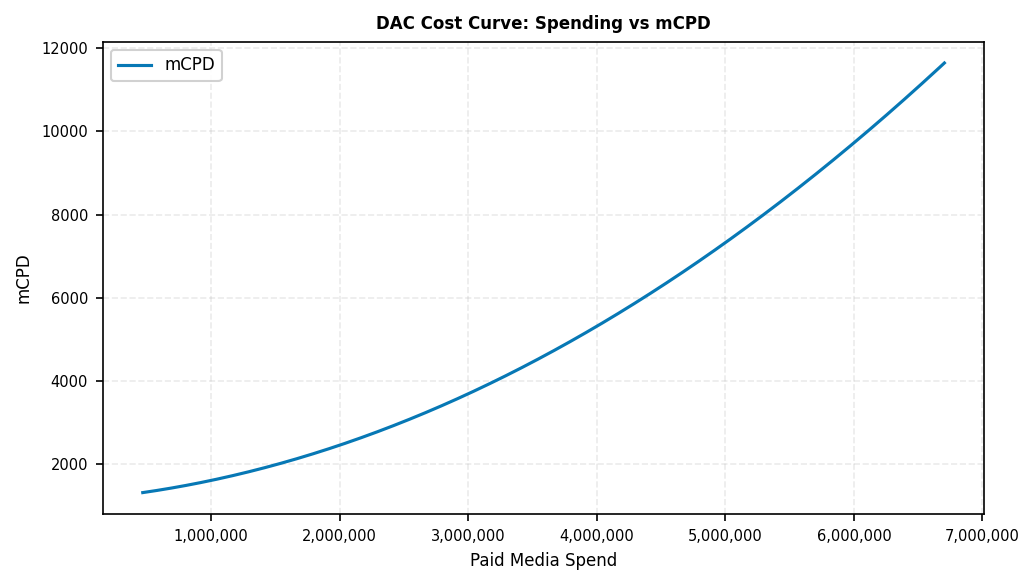

In [52]:
# Plot line graph: spending vs pred_mcpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings

# Suppress matplotlib font warnings
warnings.filterwarnings("ignore", module="matplotlib")

# Apply consistent styling from plot_mcpwad_curve
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.family": ["DejaVu Sans", "Helvetica Neue", "Arial"],  # Use DejaVu Sans to avoid font warnings
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "axes.linewidth": 0.8,
})

fig, ax = plt.subplots(figsize=(7, 4))

# Main line plot
line1, = ax.plot(
    df_fit_output['spending'], df_fit_output['pred_mcpd'],
    label="mCPD", color="#0778b5", linewidth=1.5, zorder=2
)

# Formatting consistent with plot_mcpwad_curve
ax.set_xlabel("Paid Media Spend", fontsize=8)
ax.set_ylabel("mCPD", fontsize=8)
ax.set_title("DAC Cost Curve: Spending vs mCPD", fontweight="bold", fontsize=8)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))  # commas

# Set smaller tick label sizes
ax.tick_params(axis='both', which='major', labelsize=7)  # Make tick labels smaller
# Alternative: set different sizes for each axis
# ax.tick_params(axis='x', which='major', labelsize=6)    # Even smaller for x-axis
# ax.tick_params(axis='y', which='major', labelsize=6)    # Even smaller for y-axis

# Spine formatting
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)
    spine.set_color("black")

ax.legend(handles=[line1], fontsize=8, framealpha=0.9, loc="upper left")
fig.tight_layout()
plt.show()
